In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

from functools import partial
import itertools as it

import pandas as pd
import numpy as np
import datetime as dt
import os, sys

from pathlib import Path

import torch
import ray
from ray import train, tune

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm import tqdm
from wrapt_timeout_decorator import timeout

from src.datasets import daocensus_text
from src.utils import Timer
from src.utils import notebooks as nbutils
from src import paths

%load_ext autoreload
%autoreload 2

### Parameters

In [2]:
JOBLIB_CACHE_DIR = './.cache/11_pln-tune'

TRANSFORMER_MODEL = "all-mpnet-base-v2"
ORG_NAME = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = True

# Evaluation
# N_SPLITS: int = 10
# SKIP_SPLIT: int = 0
K_RECOMMENDATIONS: List[int] = [5, 10]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_SPLITS = 10 # Use just last 10 splits
CUTOFF_DATE_STR: str = '2023-07-29'

MDF_FILE: str = None

# k for K Nearest Neighbors
# KNN_K: int = 1

# In the PLN knn model, first if trains with one set of hparams
# If it takes more than this number of seconds to do just one
# It explores a much simple space
PLN_KNN_TEST_ALL_CUTOFF_SECONDS: int = 60

GRAPHS_METRIC = 'map@10'

In [3]:
# Parameters
ORG_NAME = "MetaCartel - MetaCartel Ventures"
ORG_PLATFORM = ["daohaus", "snapshot"]
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-08 10:00"
CUTOFF_DATE_STR = "2020-11-06"


In [4]:
CUTOFF_DATE = dt.datetime.fromisoformat(CUTOFF_DATE_STR) if CUTOFF_DATE_STR else None

print('CUTOFF_DATE', CUTOFF_DATE, type(CUTOFF_DATE))
# Metrics Dataframe
MDF_FILE = Path(MDF_FILE) if MDF_FILE else paths.pln_mdf(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE)
print(MDF_FILE)

CUTOFF_DATE 2020-11-06 00:00:00 <class 'datetime.datetime'>
data/pln/mdf_MetaCartel - MetaCartel Ventures_W-THU_normalize-cutoff_date=2020-11-06 00:00:00.pkl


In [5]:
# dfptext = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfv['voter'] = dfv['voter'].astype('str')
# dfp = dfp.merge(dfptext, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

print(ORG_NAME, ORG_PLATFORM, USE_ORG_NAMES, CUTOFF_DATE)
dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES, cutoff_date=CUTOFF_DATE)
dfv[['voter', 'proposal']] = dfv[['voter', 'proposal']].astype(str)
dfp[['id']] = dfp[['id']].astype(str)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

MetaCartel - MetaCartel Ventures ['daohaus', 'snapshot'] True 2020-11-06 00:00:00


platform                              name  \
0     daohaus  MetaCartel - MetaCartel Ventures   
1     daohaus  MetaCartel - MetaCartel Ventures   
2     daohaus  MetaCartel - MetaCartel Ventures   
3     daohaus  MetaCartel - MetaCartel Ventures   
4     daohaus  MetaCartel - MetaCartel Ventures   
...       ...                               ...   
1100  daohaus  MetaCartel - MetaCartel Ventures   
1101  daohaus  MetaCartel - MetaCartel Ventures   
1102  daohaus  MetaCartel - MetaCartel Ventures   
1103  daohaus  MetaCartel - MetaCartel Ventures   
1104  daohaus  MetaCartel - MetaCartel Ventures   

                                        id  \
0     a7a47c63-4c4d-58ae-88ee-f6ce6946d088   
1     f1a74998-e2f3-55f0-964e-f3a8aa56c5c5   
2     ae6f03c5-adb5-50d5-849b-761a928ec3f6   
3     c00e1243-5304-521c-8c98-eae0c80619b4   
4     98963761-315a-530b-9210-aaae317182b1   
...                                    ...   
1100  b6e5b58c-3f16-51ec-b4a7-4f7be375709a   
1101  646da2cf-29ba-5257-9396-0dba4ed0310f   
1102  f9760482-0a78-55d2-8ac0-750a29b7670a   
1103  44f10cb1-5a02-5602-b979-d493de67b502   
1104  0b128a27-ff18-59d4-8422-5cad44fc308f   

                                  proposal  \
0     b23fab43-3b08-5638-b13d-0e286cadb04b   
1     18f8c9fd-9796-5802-ab78-b449c65ffb50   
2     2a062f74-c7cb-5625-b8ba-537b23ae5318   
3     3eff52ec-93aa-5c41-9ff2-3a18d278d138   
4     b21a24a0-1a16-55a1-8c0e-c97ed7cf8e69   
...                                    ...   
1100  ed418dda-7d6f-5e96-abfc-be7e834082b6   
1101  b1ee7c7d-25d9-5fe4-90d3-7cac48beadda   
1102  ea49447a-f0a2-5bba-8ad5-45df68670c67   
1103  0dc04c0d-be1b-5b91-8454-d465ac413f96   
1104  fc50a86f-b886-5c9f-be4d-d35bf43dcef0   

                                deployment  \
0     b5c669ac-488c-5b91-82cc-e98add7af0b7   
1     b5c669ac-488c-5b91-82cc-e98add7af0b7   
2     b5c669ac-488c-5b91-82cc-e98add7af0b7   
3     b5c669ac-488c-5b91-82cc-e98add7af0b7   
4     b5c669ac-488c-5b91-82cc-e98add7af0b7   
...                                    ...   
1100  899cc74b-f242-5fd2-a270-763436927977   
1101  899cc74b-f242-5fd2-a270-763436927977   
1102  899cc74b-f242-5fd2-a270-763436927977   
1103  899cc74b-f242-5fd2-a270-763436927977   
1104  899cc74b-f242-5fd2-a270-763436927977   

                                          platform_vote  \
0     0x0372f3696fa7dc99801f435fd6737e57818239f2-mem...   
1     0x0372f3696fa7dc99801f435fd6737e57818239f2-mem...   
2     0x0372f3696fa7dc99801f435fd6737e57818239f2-mem...   
3     0x0372f3696fa7dc99801f435fd6737e57818239f2-mem...   
4     0x0372f3696fa7dc99801f435fd6737e57818239f2-mem...   
...                                                 ...   
1100  0x4570b4faf71e23942b8b9f934b47ccedf7540162-mem...   
1101  0x4570b4faf71e23942b8b9f934b47ccedf7540162-mem...   
1102  0x4570b4faf71e23942b8b9f934b47ccedf7540162-mem...   
1103  0x4570b4faf71e23942b8b9f934b47ccedf7540162-mem...   
1104  0x4570b4faf71e23942b8b9f934b47ccedf7540162-mem...   

                                           voter                date choice  \
0     0x0eabffd8ce94ab2387fc44ba32642af0c58af433 2020-04-01 03:11:46      1   
1     0x0eabffd8ce94ab2387fc44ba32642af0c58af433 2020-06-17 03:08:43      1   
2     0x0eabffd8ce94ab2387fc44ba32642af0c58af433 2019-07-25 20:06:53      1   
3     0x0eabffd8ce94ab2387fc44ba32642af0c58af433 2019-07-30 18:13:46      1   
4     0x0eabffd8ce94ab2387fc44ba32642af0c58af433 2019-08-06 18:25:25      1   
...                                          ...                 ...    ...   
1100  0xfdc6a17917115498a3ed417d4a89224685f26ea3 2020-10-13 16:30:12      1   
1101  0xfdc6a17917115498a3ed417d4a89224685f26ea3 2020-10-20 03:11:35      1   
1102  0xfdc6a17917115498a3ed417d4a89224685f26ea3 2020-10-20 03:11:52      1   
1103  0xfdc6a17917115498a3ed417d4a89224685f26ea3 2020-10-20 03:11:52      1   
1104  0xfdc6a17917115498a3ed417d4a89224685f26ea3 2020-10-27 18:44:01      1   

      weight  
0        NaN  
1        NaN  
2        NaN  
3        NaN  


Warning, removing 1105 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1105 entries, 0 to 1104
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   platform       1105 non-null   object        
 1   name           1105 non-null   object        
 2   id             1105 non-null   object        
 3   proposal       1105 non-null   object        
 4   deployment     1105 non-null   object        
 5   platform_vote  1105 non-null   object        
 6   voter          1105 non-null   object        
 7   date           1105 non-null   datetime64[ns]
 8   choice         1105 non-null   object        
 9   weight         686 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 95.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, 2a062f74-c7cb-5625-b8ba-537b23ae5318 to 411dc063-5cd7-5de3-ac9a-5c9dba3f721a
Data columns (total 12 

## Getting the embeddings of each proposal

In [6]:
from sentence_transformers import SentenceTransformer
import pickle

str(model)
```
SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)
```

hash(str(model)) = 1078797550815066609

In [7]:
model = SentenceTransformer(TRANSFORMER_MODEL)

In [8]:
from src.models.nlp import get_embeddings_from_cache

model = SentenceTransformer(TRANSFORMER_MODEL)
print(model)
embeddings = get_embeddings_from_cache(dfp, model)

# We have to delete the model because it complains about forking
del model
# ids = embeddings.index
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

2024-03-09 08:15:18.395662: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 08:15:18.395686: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 08:15:18.395701: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)
All embeddings are already calculated


In [9]:
embeddings_sum = embeddings.sum(axis=0)
print(embeddings.shape, embeddings_sum.shape)
embeddings = embeddings.apply(lambda x: x / embeddings_sum)
embeddings

(373,) (768,)


id
2a062f74-c7cb-5625-b8ba-537b23ae5318    [0.0053619323, 0.0029296754, -0.0026650855, 0....
9013374b-028a-5a7b-8b6a-95079c23f99e    [0.0048854207, 0.007195598, 0.0025023418, 0.00...
e473d69a-04e8-5e28-b609-1a55b698351c    [0.0038528352, 0.011546231, 0.0039255084, 0.00...
5471b1ef-9492-57d1-a3ad-7894cbfc18cd    [0.01405283, 0.010552851, -0.0032659138, 0.016...
57f4ceee-4abb-5d0d-bebf-24ae552f3656    [0.0056888545, 0.0049816775, 0.007084623, 0.00...
                                                              ...                        
3362b375-573e-598e-978a-b7d7d3d0f60f    [0.0025422564, -0.0010741148, -0.026476627, 0....
fd269cf9-de0b-576e-9c52-e0236f92e243    [0.0073005287, -0.0048108012, -0.0024054106, 0...
c93d40d0-1671-549a-973c-fe8a9b576406    [0.0013113831, -0.0027935347, -0.004309634, 0....
49c5fff0-672f-5332-a486-2fa2bfa78aef    [0.0024661398, 0.00064929033, 0.01145855, -0.0...
411dc063-5cd7-5de3-ac9a-5c9dba3f721a    [-0.0024823996, 0.0022096946, 0.018924, 0.0032...
Length:

In [10]:
dfp['embeddings'] = embeddings

## Getting the embeddings of each user

The embeddings of each user are the embeddings of each proposal the user has voted in

In [11]:
# dfp['nbidx'] = dfp.index
# _dfv = dfv.merge(dfp[['id', 'nbidx']], how='left', left_on='proposal', right_on='id')
# print('dfp:', dfp.shape, 'dfv:', dfv.shape, '_dfv:', _dfv.shape)
# votes_embeddings = embeddings[_dfv['nbidx']]
votes_embeddings = embeddings.loc[dfv['proposal']]
print('dfp:', dfp.shape, 'dfv:', dfv.shape)
votes_embeddings.shape

dfp: (373, 13) dfv: (1105, 10)


(1105,)

In [12]:
# observed = True, because voter is categorical and might have no votes really
voter_embeddings = dfv.groupby('voter', observed=True).apply(lambda x: votes_embeddings[x.index].sum(axis=0))
voter_embeddings = voter_embeddings.apply(lambda x: x/np.linalg.norm(x))
# msk = (np.linalg.norm(np.stack(voter_embeddings.to_numpy()), axis=1) > 0.9)
voter_embeddings

voter
0x06601571aa9d3e8f5f7cdd5b993192618964bab5    [0.0063951383, 0.0036070677, 0.0062679467, 0.0...
0x0eabffd8ce94ab2387fc44ba32642af0c58af433    [0.004782884, 0.005478198, 0.0052445643, 0.003...
0x11df180d9bdbe90fa51898b3d59959549d589426    [0.0027508016, -0.0017801926, -0.000534651, 0....
0x1289f94bcc60ed9f894ab9d5a54c21b3d4b3f2da    [0.0010701924, 0.0042284853, 0.0041816407, 0.0...
0x1bef65e44adc3fb394cecca4750a1666310e6e2e    [0.004170979, 0.0020558357, 0.005003567, 0.002...
                                                                    ...                        
0xf7f189082878846c11a94ddac51c41afc7a7c772    [0.0034193979, 0.0036491407, 0.0002554522, 0.0...
0xf8a685702347377e396486967399f33c6c0c0a29    [0.0026930743, 0.0026091714, 0.0026843136, 0.0...
0xfafd1d1d502ba454a5fb3d89ede92a45bf8d8d8f    [0.0026225534, 0.0008200375, 0.0076404954, 0.0...
0xfdc6a17917115498a3ed417d4a89224685f26ea3    [0.004279718, 0.0014618227, 0.005112526, 0.001...
0xffd1ac3e8818adcbe5c597ea076e8d32

In [13]:
dfv.groupby('voter', observed=True).size().sort_values()

voter
0x8f942eced007bd3976927b7958b50df126feecb5      1
0x9492510bbcb93b6992d8b7bb67888558e12dcac4      1
0x57db4c6e862e4144ff48b67732d2ccb5af9de14c      1
0xc6b0a4c5ba85d082ecd4fb05fbf63eb92ac1083a      1
0xb6ef7fffd7ae5718287d04cb6a077197e3240fc0      1
                                             ... 
0xbaf6e57a3940898fd21076b139d4ab231dcbbc5f     50
0xd26a3f686d43f2a62ba9eae2ff77e9f516d945b9     53
0xe2a82cdccbfa6ebf9817b0c4aed45264bd41fbec     54
0xc864c34b7313e55bc832b857d8de55ff0f0d0b28    106
0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88    130
Length: 96, dtype: int64

## Making recommendations with cosine similarity

Because they are normalized, our ranking score can be just the dot product of a user and a proposal

In [14]:
embeddings_np = np.vstack(embeddings)

In [15]:
# user_emb = voter_embeddings['0x613e052555ac74ff6af0fc64e40e8035c1e9dcf8']
# scores = embeddings_np @ user_emb
# scores.argsort()

In [16]:
def recommend_emb(emb, k, t = None):
    """
    Args:
        emb: The embedding of the item/user to recommend items to
        k (int): The number of items to recommend
        t (timestamp): Simulate that the recommendation is made at time `t`
            i.e: Filter out already closed proposals or not yet open
    """
    # 1D n_proposals
    scores = embeddings_np @ emb

    if t:
        msk = (dfp['start'] < t) & (t < dfp['end'])
        scores[msk] = -np.inf
    
    best = (-scores).argsort()

    dfbest = dfp.iloc[best[:k]].copy()
    dfbest['score'] = scores[best[:k]]
    return dfbest

In [17]:
def recommend_user(voter: str, k: int = 5, t: Optional[np.datetime64] = None):
    # 1D emb_size
    user_emb = voter_embeddings[voter]
    return recommend_emb(user_emb, k, t)

# recommend_user('0x613e052555ac74ff6af0fc64e40e8035c1e9dcf8')[['title', 'description', 'score']]

In [18]:
def recommend_proposal(proposal: str, k: int = 5, t: Optional[np.datetime64] = None):
    # 1D emb_size
    prop_emb = dfp['embeddings'][proposal]
    return recommend_emb(prop_emb, k, t)

# display(dfp.loc['433b7e43-77b0-5ea1-bac3-0c3071363a56'])
# recommend_proposal('433b7e43-77b0-5ea1-bac3-0c3071363a56')

### Evaluation

First, we will evaluate if the user recommendations are any good using common off-line metrics.

In [19]:
assert not any(voter_embeddings.isna()), "Hay embeddings NA"

In [20]:
np.vstack(voter_embeddings)

array([[ 0.00639514,  0.00360707,  0.00626795, ...,  0.02001015,
         0.00439718,  0.00071826],
       [ 0.00478288,  0.0054782 ,  0.00524456, ..., -0.00082641,
         0.00288238,  0.00147902],
       [ 0.0027508 , -0.00178019, -0.00053465, ..., -0.00303268,
         0.00219137,  0.00056394],
       ...,
       [ 0.00262255,  0.00082004,  0.0076405 , ..., -0.02108281,
         0.00142444,  0.00405409],
       [ 0.00427972,  0.00146182,  0.00511253, ..., -0.00833723,
         0.00424085,  0.00311396],
       [ 0.00141789,  0.00317247,  0.00115551, ...,  0.00176599,
         0.00076862, -0.00125176]], dtype=float32)

In [21]:
def recommendNLPNaive(train: pd.DataFrame, users, proposals, k: int = 5, remove_training: bool = True, min_score: float = 0):  
    # Create voter embeddings (filtering that they are in train)
    # TODO: Add some kind of discount rate over time
    # TODO: DELETEME
    aux = dfv[dfv['voter'].isin(users) & dfv['proposal'].isin(train['itemID'])]
    assert not aux.empty, "Aux is empty"
    not_in_train = set(users).difference(dfv[dfv['proposal'].isin(train['itemID'])]['voter'])
    # print('aux.shape:', aux.shape)
    # print('not in train (in):', len(not_in_train))

    voter_embeddings = aux.groupby('voter', observed=True).apply(lambda x: votes_embeddings[x.index].sum(axis=0))
    voter_embeddings = voter_embeddings.apply(lambda x: x/np.linalg.norm(x))
    assert not voter_embeddings.empty, "Voter embeddings is empty!"
    # np_voter_embeddings = np.stack(voter_embeddings.to_numpy())
    np_voter_embeddings = np.vstack(voter_embeddings)
    
    # Remove score from proposals not in `proposals`
    msk = embeddings.index.isin(proposals)
    tr_embeddings = np.vstack(embeddings).copy()
    tr_embeddings[~msk] = 0
    
    scores = np_voter_embeddings @ tr_embeddings.T
    
    # Remove score from proposals already voted by user
    if remove_training:
        trainu = train[train['userID'].isin(users)]
        itemID2idx = pd.Series(data=np.arange(len(dfp)), index=dfp.index.astype(str))
        voterID2idx = pd.Series(data=np.arange(len(voter_embeddings)), index=voter_embeddings.index)
        scores[voterID2idx[trainu['userID']], itemID2idx[trainu['itemID']]] = -np.inf
        
    best = (-scores).argsort(axis=1)
    topk = best[:, :k]
    
    # create df with columns
    # userID, itemID, prediction
    uid = np.repeat(np.arange(np_voter_embeddings.shape[0]), k)
    iid = topk.flatten()
    
    # transform int to id
    df = pd.DataFrame({
        'userID': voter_embeddings.index[uid],
        'itemID': dfp.index[iid].astype(str),
        # 'prediction': 1,
        'prediction': scores[uid, iid],
    })
    return df[df['prediction'] > min_score].reset_index(drop=True)

# train = train_filtered
# users = test_filtered['userID'].unique()
# proposals = test_filtered['itemID'].unique()
# k = 3
# remove_training = True

In [22]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from src.datasets import to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent

In [23]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

### Evaluation in multiple months

In [24]:
df = to_microsoft(dfv)
folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'))[-LAST_SPLITS:]
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, } # 'recall': recall_at_k, 

def testHParamsSimilarity(fold, window_size):
    metrics = dict()

    train, test, t, open_proposals = folds[fold]
    offset = pd.tseries.frequencies.to_offset(window_size)

    train_filtered = train[train['timestamp'] > (t - offset)]
    not_in_train = set(test['userID']).difference(train['userID'])
    # print('not in train:', len(not_in_train))
    # print('not in train filtered:', len(not_in_train))
    for k_recs in K_RECOMMENDATIONS:
        with Timer() as t:
            recs = recommendNLPNaive(train_filtered, test['userID'].unique(), open_proposals, k_recs)

        metrics[f'time@{k_recs}'] = t.time
        for m, f in metrics_f.items():
            metrics[m+f'@{k_recs}'] = f(test, recs, k=k_recs)

    return metrics

testHParamsSimilarity(0, '14d')
# testHParamsSimilarity(1, '2W')

{'time@5': 0.004364266991615295,
 'precision@5': 0.05,
 'ndcg@5': 0.25,
 'map@5': 0.25,
 'time@10': 0.004194596782326698,
 'precision@10': 0.05,
 'ndcg@10': 0.29179011374155056,
 'map@10': 0.2638888888888889}

In [25]:
from sklearn.model_selection import ParameterGrid

param_grid = ParameterGrid({
    'fold': range(len(folds)),
    'window_size': ['7d', '14d', '30d', '90d', '180d', '360d', '10Y'],
})

results = list()
for p in tqdm(param_grid):
    results.append(testHParamsSimilarity(**p) | p)

mdf = pd.DataFrame(results).set_index(['fold', 'window_size'])
mdf

  0%|          | 0/70 [00:00<?, ?it/s]

  3%|▎         | 2/70 [00:00<00:03, 17.31it/s]

  6%|▌         | 4/70 [00:00<00:03, 17.33it/s]

  9%|▊         | 6/70 [00:00<00:03, 17.29it/s]

 11%|█▏        | 8/70 [00:00<00:03, 17.16it/s]

 14%|█▍        | 10/70 [00:00<00:03, 16.86it/s]

 17%|█▋        | 12/70 [00:00<00:03, 17.06it/s]

 20%|██        | 14/70 [00:00<00:03, 17.16it/s]

 23%|██▎       | 16/70 [00:00<00:03, 17.15it/s]

 26%|██▌       | 18/70 [00:01<00:03, 17.11it/s]

 29%|██▊       | 20/70 [00:01<00:02, 17.03it/s]

 31%|███▏      | 22/70 [00:01<00:02, 17.08it/s]

 34%|███▍      | 24/70 [00:01<00:02, 17.20it/s]

 37%|███▋      | 26/70 [00:01<00:02, 17.24it/s]

 40%|████      | 28/70 [00:01<00:02, 17.25it/s]

 43%|████▎     | 30/70 [00:01<00:02, 17.23it/s]

 46%|████▌     | 32/70 [00:01<00:02, 17.21it/s]

 49%|████▊     | 34/70 [00:01<00:02, 17.08it/s]

 51%|█████▏    | 36/70 [00:02<00:02, 16.96it/s]

 54%|█████▍    | 38/70 [00:02<00:01, 16.78it/s]

 57%|█████▋    | 40/70 [00:02<00:01, 16.49it/s]

 60%|██████    | 42/70 [00:02<00:01, 16.25it/s]

 64%|██████▍   | 45/70 [00:02<00:01, 18.09it/s]

 69%|██████▊   | 48/70 [00:02<00:01, 19.22it/s]

 71%|███████▏  | 50/70 [00:02<00:01, 19.32it/s]

 74%|███████▍  | 52/70 [00:02<00:00, 18.81it/s]

 77%|███████▋  | 54/70 [00:03<00:00, 18.43it/s]

 80%|████████  | 56/70 [00:03<00:00, 18.15it/s]

 83%|████████▎ | 58/70 [00:03<00:00, 17.95it/s]

 86%|████████▌ | 60/70 [00:03<00:00, 16.84it/s]

 89%|████████▊ | 62/70 [00:03<00:00, 16.83it/s]

 91%|█████████▏| 64/70 [00:03<00:00, 16.90it/s]

 94%|█████████▍| 66/70 [00:03<00:00, 17.06it/s]

 97%|█████████▋| 68/70 [00:03<00:00, 17.16it/s]

100%|██████████| 70/70 [00:04<00:00, 17.22it/s]

100%|██████████| 70/70 [00:04<00:00, 17.36it/s]

time@5  precision@5    ndcg@5     map@5   time@10  \
fold window_size                                                        
0    7d           0.004338         0.10  0.300527  0.270833  0.004155   
     14d          0.004116         0.05  0.250000  0.250000  0.004016   
     30d          0.004209         0.10  0.324020  0.291667  0.004081   
     90d          0.004273         0.05  0.096713  0.050000  0.004211   
     180d         0.004419         0.05  0.096713  0.050000  0.004300   
...                    ...          ...       ...       ...       ...   
9    30d          0.004190         0.24  0.887349  0.855556  0.004145   
     90d          0.004385         0.24  0.887349  0.855556  0.004197   
     180d         0.004482         0.16  0.487349  0.455556  0.004376   
     360d         0.004523         0.16  0.487349  0.455556  0.004431   
     10Y          0.004528         0.16  0.487349  0.455556  0.004449   

                  precision@10   ndcg@10    map@10  
fold window_size                                    
0    7d                  0.075  0.342317  0.284722  
     14d                 0.050  0.291790  0.263889  
     30d                 0.075  0.359337  0.310185  
     90d                 0.025  0.096713  0.050000  
     180d                0.025  0.096713  0.050000  
...                        ...       ...       ...  
9    30d                 0.120  0.887349  0.855556  
     90d                 0.120  0.887349  0.855556  
     180d                0.100  0.558591  0.488889  
     360d                0.100  0.558591  0.488889  
     10Y                 0.100  0.558591  0.488889  

[70 rows x 8 columns]

<Axes: xlabel='fold', ylabel='precision@5'>

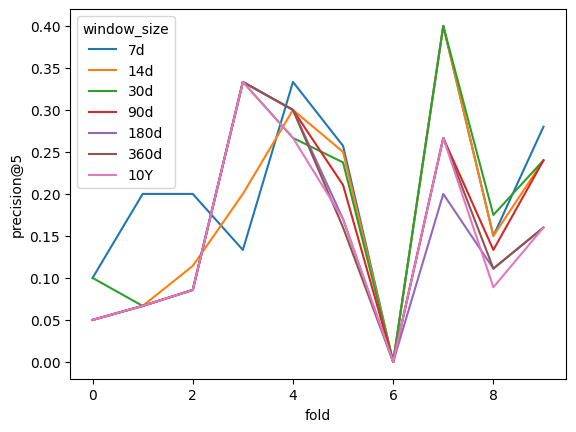

In [26]:
sns.lineplot(mdf, x='fold', y='precision@5', hue='window_size')

In [27]:
mdf.groupby('window_size').describe().drop(columns=['time@10', 'ndcg@10']).T

window_size               10Y        14d       180d        30d       360d  \
time@5       count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.004804   0.004605   0.004852   0.004349   0.004714   
             std     0.000755   0.001079   0.000934   0.000458   0.000778   
             min     0.003916   0.003965   0.003992   0.003937   0.003871   
             25%     0.004333   0.004042   0.004243   0.004048   0.004331   
             50%     0.004688   0.004175   0.004451   0.004200   0.004478   
             75%     0.004971   0.004411   0.005063   0.004507   0.004844   
             max     0.006628   0.007411   0.006594   0.005480   0.006700   
precision@5  count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.148794   0.177095   0.147683   0.190488   0.153349   
             std     0.109864   0.124266   0.107573   0.127274   0.112989   
             min     0.000000   0.000000   0.000000   0.000000   0.000000   
             25%     0.071429   0.078571   0.071429   0.089286   0.071429   
             50%     0.124444   0.175000   0.135556   0.206250   0.135556   
             75%     0.242500   0.247500   0.192500   0.260000   0.240000   
             max     0.333333   0.400000   0.333333   0.400000   0.333333   
ndcg@5       count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.332154   0.469584   0.353806   0.494451   0.360125   
             std     0.227442   0.284160   0.255384   0.283574   0.251601   
             min     0.000000   0.000000   0.000000   0.000000   0.000000   
             25%     0.181317   0.253142   0.181317   0.288595   0.181317   
             50%     0.310656   0.499356   0.315986   0.554884   0.357013   
             75%     0.466562   0.705615   0.478334   0.715456   0.478334   
             max     0.724852   0.845652   0.800283   0.887349   0.771822   
map@5        count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.278444   0.418325   0.303930   0.436144   0.307750   
             std     0.206444   0.258517   0.233161   0.268946   0.231828   
             min     0.000000   0.000000   0.000000   0.000000   0.000000   
             25%     0.139881   0.225000   0.139881   0.251488   0.139881   
             50%     0.251514   0.443452   0.263204   0.445469   0.282301   
             75%     0.422685   0.617374   0.445833   0.644097   0.445833   
             max     0.633333   0.768519   0.716667   0.855556   0.687500   
precision@10 count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.093603   0.118048   0.099103   0.116881   0.104103   
             std     0.065336   0.071394   0.074408   0.072578   0.070450   
             min     0.000000   0.000000   0.000000   0.000000   0.000000   
             25%     0.055952   0.061607   0.055952   0.068750   0.059524   
             50%     0.083333   0.120000   0.083333   0.103750   0.087500   
             75%     0.128750   0.181250   0.130000   0.165625   0.130000   
             max     0.200000   0.200000   0.233333   0.233333   0.233333   
map@10       count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.304776   0.453557   0.335057   0.462480   0.339412   
             std     0.222402   0.251593   0.254299   0.262997   0.249372   
             min     0.000000   0.000000   0.000000   0.000000   0.000000   
             25%     0.164484   0.283333   0.164484   0.273975   0.164484   
             50%     0.276527   0.443452   0.295525   0.511342   0.302482   
             75%     0.447685   0.662067   0.470833   0.654514   0.470833   
             max     0.680952   0.777778   0.797619   0.855556   0.750000   

window_size                7d        90d  
time@5       count  10.000000  10.000000  
             mean    0.004266   0.006448  
             std     0.000431   0.006142  
             min     0.003665   0.003872  
           

In [28]:
from src import baseline

# bdf = pd.read_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))[-LAST_SPLITS:]
bdf = baseline.read_metrics_baseline(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE)[-LAST_SPLITS:]
assert bdf.index.max() < CUTOFF_DATE if CUTOFF_DATE else True
bdf['fold'] = np.arange(10)
bdf.describe()

precision@5     ndcg@5      map@5   recall@5  precision@10    ndcg@10  \
count    10.000000  10.000000  10.000000  10.000000     10.000000  10.000000   
mean      0.115603   0.207172   0.154883   0.321443      0.083119   0.255916   
std       0.125702   0.205059   0.149495   0.362451      0.067743   0.188399   
min       0.000000   0.000000   0.000000   0.000000      0.000000   0.000000   
25%       0.011111   0.024673   0.013889   0.027778      0.035000   0.130420   
50%       0.061905   0.150911   0.140873   0.182540      0.058929   0.200940   
75%       0.215833   0.354948   0.253993   0.513264      0.132778   0.404688   
max       0.333333   0.576308   0.434444   1.000000      0.200000   0.576308   

          map@10  recall@10  precision@15    ndcg@15     map@15  recall@15  \
count  10.000000  10.000000     10.000000  10.000000  10.000000  10.000000   
mean    0.178399   0.453488      0.060365   0.276224   0.184806   0.527774   
std     0.142065   0.329442      0.043450   0.180912   0.137198   0.363607   
min     0.000000   0.000000      0.000000   0.000000   0.000000   0.000000   
25%     0.067832   0.238095      0.026190   0.172712   0.100825   0.253958   
50%     0.149802   0.374583      0.058333   0.242755   0.154563   0.492063   
75%     0.282951   0.722222      0.088519   0.411288   0.282951   0.819444   
max     0.434444   1.000000      0.133333   0.576308   0.434444   1.000000   

           fold  
count  10.00000  
mean    4.50000  
std     3.02765  
min     0.00000  
25%     2.25000  
50%     4.50000  
75%     6.75000  
max     9.00000

In [29]:
# pdf = pd.read_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))[-LAST_SPLITS:]
pdf = baseline.read_metrics_perfect(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE)[-LAST_SPLITS:]
pdf['fold'] = np.arange(10)
pdf.describe()

precision@5  ndcg@5      map@5   recall@5  precision@10  ndcg@10  \
count    10.000000    10.0  10.000000  10.000000     10.000000     10.0   
mean      0.319524     1.0   0.997315   0.997315      0.161373      1.0   
std       0.120887     0.0   0.006149   0.006149      0.063358      0.0   
min       0.200000     1.0   0.981481   0.981481      0.100000      1.0   
25%       0.207143     1.0   1.000000   1.000000      0.103571      1.0   
50%       0.295556     1.0   1.000000   1.000000      0.147778      1.0   
75%       0.400000     1.0   1.000000   1.000000      0.200000      1.0   
max       0.555556     1.0   1.000000   1.000000      0.288889      1.0   

       map@10  recall@10  precision@15  ndcg@15  map@15  recall@15      fold  
count    10.0       10.0     10.000000     10.0    10.0       10.0  10.00000  
mean      1.0        1.0      0.107582      1.0     1.0        1.0   4.50000  
std       0.0        0.0      0.042239      0.0     0.0        0.0   3.02765  
min       1.0        1.0      0.066667      1.0     1.0        1.0   0.00000  
25%       1.0        1.0      0.069048      1.0     1.0        1.0   2.25000  
50%       1.0        1.0      0.098519      1.0     1.0        1.0   4.50000  
75%       1.0        1.0      0.133333      1.0     1.0        1.0   6.75000  
max       1.0        1.0      0.192593      1.0     1.0        1.0   9.00000

Cannot show ipywidgets in text

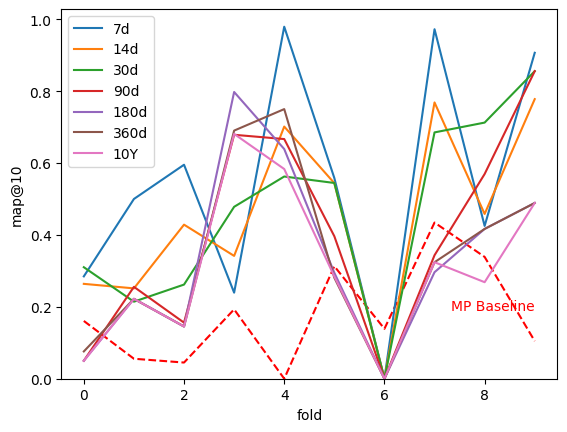

In [30]:
_METRICS = ['map@5', 'map@10']
_METRIC = _METRICS[-1]

ax = sns.lineplot(mdf, x='fold', y=_METRIC, hue='window_size')
ax = sns.lineplot(bdf, x='fold', y=_METRIC, color='red', zorder=0)
ax.lines[-1].set_linestyle('--')
ax.text(9, 0.19, "MP Baseline", ha='right', color=ax.lines[-1].get_color())

# ax = sns.lineplot(pdf, x='fold', y=_METRIC, color='blue')
# ax.lines[-1].set_linestyle(':')

ax.set_ylim((0,None));
nbutils.download_matplotlib(ax.figure, f'11_cosine_results_results-lines_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

<class 'matplotlib.figure.Figure'>


Cannot show ipywidgets in text

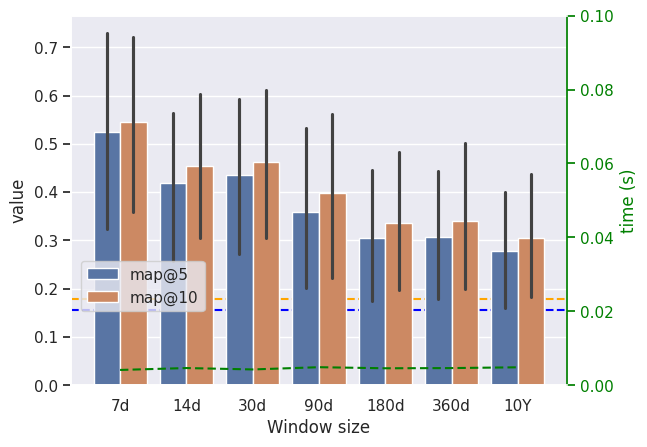

<Figure size 640x480 with 0 Axes>

In [31]:
# _METRIC = 'precision@5'

topline = pdf[_METRIC].mean()

_toplot = mdf[_METRICS].melt(value_vars=_METRICS, var_name='metric', ignore_index=False)

sns.set_theme()
ax = sns.barplot(_toplot, x='window_size', y='value', hue='metric')
ax.set_xlabel("Window size")

baseline = bdf[_METRICS[0]].mean()
ax.axhline(baseline, ls='--', color='blue', zorder=0)
baseline = bdf[_METRICS[1]].mean()
ax.axhline(baseline, ls='--', color='orange', zorder=0)
# ax.text(0, baseline-0.005, "map@5", color='black', ha='left', va='top', fontsize='large')

if not _METRIC.startswith('map@'):
    ax.axhline(topline, ls=':', color='blue')
    ax.text(0, topline-0.005, "perfect", color='blue', ha='left', va='top')

ax2 = ax.twinx()
time_color = 'green'
sns.lineplot(mdf, x='window_size', y='time@10', color=time_color, ax=ax2, markers=True, dashes=(4,2), errorbar=None)
ax2.set_ylabel('time (s)', color=time_color)
ax2.tick_params(axis='y', color=time_color)
ax2.spines['right'].set_color(time_color)
[t.set_color(time_color) for t in ax2.yaxis.get_ticklabels()]
ax2.grid(False)
ax2.set_ylim((0,.10))

ax.legend(loc=(0.02,.2))

print(type(plt.figure()))
nbutils.download_matplotlib(ax.figure, f'11_cosine_results_window-size_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

# Second iteration: PLN with kNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier

# itemID2idx = pd.Series(data=np.arange(len(dfp)), index=dfp.index.astype(str))
# itemID2idx

In [33]:
def filter_proposals_in_train(train, user, proposals):
    msk = train['userID'] == user
    proposals_aready_voted_by_user = train[msk]['itemID'].unique()
    return np.setdiff1d(proposals, proposals_aready_voted_by_user)

In [34]:
from joblib import Memory

# memory = Memory(JOBLIB_CACHE_DIR, mmap_mode='c', verbose=0)

# @memory.cache
def recommendUserKNN(train: pd.DataFrame, user, proposals, top_k: Optional[int] = None, knn_k = 3, do_sampling: Optional[bool] = None, remove_train: bool = True, metric=None):
    """
    Given the train data (proposals that might be voted or not by the user), recommend k proposals from proposals to the user
    The train data is a DataFrame in microsoft's format
    
    do_sampling (bool) : default None
        if True, makes sampling so the number of positive and negative samples is the same
        if False, doesn't do it
        if None (default), does it when k > 0, but doesn't do it with Nearest Neighbor
    """
    # train['hasVoted'] = train['userID'] == user
    hasVoted = train['userID'] == user

    # Remove recommendations already in training
    # (aka remove from proposals array)
    if remove_train:
        proposals = filter_proposals_in_train(train, user, proposals)

    assert any(hasVoted), 'The user has not voted in any proposal'
    if knn_k == 0:
        do_sampling = False
        knn_k = 1

    if do_sampling or (do_sampling is None and knn_k > 0):
        # num_samples = train['hasVoted'].value_counts().min() # [True]
        num_samples = hasVoted.value_counts().min() # [True]
        train = train.groupby(hasVoted).apply(lambda x: x.sample(num_samples)).reset_index(drop=True)
        hasVoted = train['userID'] == user

    # known_embeds = embeddings[itemID2idx[train['itemID']]]
    known_embeds = np.vstack(embeddings.loc[train['itemID']])

    assert knn_k >= 0
    knn = KNeighborsClassifier(max(knn_k, 1), metric=metric if metric else 'minkowski')
    knn.fit(known_embeds, hasVoted)# train['hasVoted'])

    predict_embeds = np.vstack(embeddings.loc[proposals])
    aux = knn.predict_proba(predict_embeds)
    p = knn.predict_proba(predict_embeds)[:, 1] # Probabilidad de que sea True

    if top_k:
        best = (1-p).argsort()[:top_k]
        p = p[best]
        proposals = proposals[best]
    
    return pd.DataFrame({
        'userID': user,
        'itemID': proposals,
        'prediction': 1,
        'score': p,
    })

# u = '0xe44782afe398800d7190796018c4b865e32ff806'
# proposals_voted_by_user = test_filtered[test_filtered['userID'] == u]
# print(f'The user {u} voted in {len(proposals_voted_by_user)} proposals')
# p = recommendUserKNN(train, u, test_filtered['itemID'].unique().copy(), 5, do_sampling=True)
# p['correct'] = p['itemID'].isin(proposals_voted_by_user['itemID'])
# p

In [35]:
from recommenders.datasets.pandas_df_utils import filter_by

def recommendMostVoted(train: pd.DataFrame, user, proposals, top_k: Optional[int] = None, remove_train=True):
    bestVotes = train[train['itemID'].isin(proposals)]['itemID'].value_counts()
    df = pd.DataFrame({
        'userID': user,
        'itemID': bestVotes.index,
        'prediction': 1,
        'score': bestVotes,
    })
    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
    return df.head(top_k).reset_index(drop=True)

# u = '0xe44782afe398800d7190796018c4b865e32ff806'
# proposals_voted_by_user = test_filtered[test_filtered['userID'] == u]
# print(f'The user {u} voted in {len(proposals_voted_by_user)} proposals')
# recommendMostVoted(train_filtered.copy(), u, test_filtered['itemID'].unique(), 5)

In [36]:
# import multiprocessing as mp
# from multiprocessing import Pool
# from multiprocessing.pool import ThreadPool as Pool

from joblib import Parallel, delayed

def recommendUserKNNwithFallback(train, user, proposals, top_k = None, knn_k: int = 1, remove_train: bool = True, do_sampling = None, metric=None):
    """ If the user has not voted in any proposal in `train`, we fall back to recommending
    the most voted proposal in `proposals`
    """
    if remove_train:
        proposals = filter_proposals_in_train(train, user, proposals)
    if (user == train['userID']).sum() >= max(knn_k, 1):
        df = recommendUserKNN(train, user, proposals, top_k, knn_k, remove_train=False, do_sampling=do_sampling, metric=metric)
        df['scoreType'] = 'knn'
        return df
    else:
        df = recommendMostVoted(train, user, proposals, top_k, remove_train=False)
        df['scoreType'] = 'mv'
        return df

def recommendNLPKNN(train: pd.DataFrame, users, proposals, top_k: int = 5, knn_k: int = 1, do_sampling=None, cpus=-1, chunksize=8, disable_tqdm=False, metric=None):
    # Create voter embeddings
    assert knn_k >= 0

    # return pd.concat(tqdm((
    #     recommendUserKNNwithFallback(train, u, proposals, top_k, knn_k, remove_train=False, do_sampling=do_sampling) for u in users
    # ), desc='users', leave=False, total=len(users)))

    p = partial(
        recommendUserKNNwithFallback, 
        train, 
        proposals=proposals, 
        top_k=top_k,
        knn_k=knn_k,
        do_sampling=do_sampling,
        metric=metric,
    )

    if cpus == 1:
        # return pd.concat(tqdm(
        return pd.concat(
            map(p, users),
            # total=len(users),
            # desc='users',
            # leave=False,
            # disable=disable_tqdm,
        )
        # ))
    else:
        # with Pool(mp.cpu_count() // 4 if cpus==-1 else cpus) as pool:
        #     return pd.concat(
        #         tqdm(
        #             pool.imap(p, users, chunksize=chunksize),
        #             total=len(users),
        #             desc='users',
        #             leave=False,
        #             disable=disable_tqdm,
        #         )
        #     )
        return pd.concat(
            Parallel()(delayed(p)(u) for u in tqdm(users, desc='users', leave=False, disable=disable_tqdm))
        )

with Timer() as timer_one:
    display(recommendNLPKNN(folds[0][0], folds[0][1]['userID'].unique(), folds[0][1]['itemID'].unique(), top_k=1))
timer_one.time

users:   0%|          | 0/4 [00:00<?, ?it/s]

userID  \
0  0x1dbef87da31986391e9d16ab9f1793ab0c9a6276   
0  0x840580fea94a641eb392fc5e0881bb1dc8c094f5   
0  0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88   
0  0xc864c34b7313e55bc832b857d8de55ff0f0d0b28   

                                 itemID  prediction  score scoreType  
0  170d0497-f8bb-596e-97b3-b7064e922dd9           1    1.0       knn  
0  f68958e2-cbf5-5d90-8f51-95bb3df8484d           1    1.0       knn  
0  170d0497-f8bb-596e-97b3-b7064e922dd9           1    1.0       knn  
0  170d0497-f8bb-596e-97b3-b7064e922dd9           1    1.0       knn

0.021349232643842697

In [37]:
# print(mp.cpu_count())

### Evaluation

Usaremos el método del codo para ver cual de todos es mejor

In [38]:
df = to_microsoft(dfv)
folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', return_open=True))[-LAST_SPLITS:]
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, } # 'recall': recall_at_k, 

def testHParamsKNN(fold, window_size, k, metric, cpus=-1, disable_tqdm=True):
    metrics = dict()

    train, test, t, open_proposals = folds[fold]
    offset = pd.tseries.frequencies.to_offset(window_size)
    train_filtered = train[train['timestamp'] > (t - offset)]

    for k_recs in K_RECOMMENDATIONS:
        with Timer() as t:
            recs = recommendNLPKNN(train_filtered, test['userID'].unique(), open_proposals, k_recs, k, disable_tqdm=disable_tqdm, metric=metric, cpus=cpus)

        metrics[f'time@{k_recs}'] = t.time
        metrics[f'knnUsage@{k_recs}'] = (recs['scoreType'] == 'knn').mean()
        for m, f in metrics_f.items():
                metrics[m+f'@{k_recs}'] = f(test, recs, k=k_recs)

    return metrics

# metrics = testHParamsKNN(0, '14d', 0, 'cosine')
# metrics

In [39]:
from sklearn.model_selection import ParameterGrid
from concurrent.futures import ProcessPoolExecutor as PoolExecutor, as_completed

# Total job timeout: 5 hours
TOTAL_TIMEOUT = 3600 * 5
MAX_WORKERS = 8

param_grid = ParameterGrid({
    'fold': range(len(folds)),
    'window_size': ['7d', '14d', '30d', '90d', '180d', '360d', '10Y'],
    'k': [1,2,3,4,5,6,7,8,9,10,15,20,30,50],
    'metric': ['minkowski', 'cosine'],
})

if timer_one.time > PLN_KNN_TEST_ALL_CUTOFF_SECONDS * 2:
    print("Warning: Using very reduced pgrid (just to keep running the notebook)", file=sys.stderr)
    param_grid = ParameterGrid({
        'fold': range(len(folds)),
        'window_size': ['7d'],
        'k': [1],
        'metric': ['cosine'],
    })
elif timer_one.time > PLN_KNN_TEST_ALL_CUTOFF_SECONDS:
    print("Warning: Using reduced pgrid", file=sys.stderr)
    param_grid = ParameterGrid({
        'fold': range(len(folds)),
        'window_size': ['7d', '14d', '30d'],
        'k': [1,2,3,4,5],
        'metric': ['cosine'],
    })

def _retDict(p):
    # @timeout(60, use_signals=True, exception_message=f"Timeout testing {p}")
    def aux(p):
        return testHParamsKNN(cpus=1, **p)

    return p, aux(p)

done = None
todo_idx = pd.MultiIndex.from_frame(pd.DataFrame(param_grid))

if MDF_FILE.exists():
    done = pd.read_pickle(MDF_FILE)
    todo_idx = todo_idx.reorder_levels(done.index.names).difference(done.index)

todo_recs = [ { n:r for n,r in zip(todo_idx.names, p)} for p in todo_idx ]

if not todo_recs:
    print("All done!")
else:
    with PoolExecutor(max_workers=MAX_WORKERS) as ex:
        fs = [ ex.submit(_retDict, p) for p in todo_recs ]
        ex.shutdown(wait=False)
    
        for f in tqdm(as_completed(fs, timeout=TOTAL_TIMEOUT), total=len(fs)):
            p, res = f.result()
            if done is None or done.empty:
                done = pd.DataFrame(res, index=pd.MultiIndex.from_tuples([p.values()], names=p.keys()))
            else:
                done.loc[tuple(p.values())] = res
                done.to_pickle(MDF_FILE)

All done!


In [40]:
KNN_ANALYZE_METRIC = 'map@10'

In [41]:
mdf = pd.read_pickle(MDF_FILE)
mdf_mean = mdf.groupby(['k', 'window_size', 'metric']).mean()
mdf_mean.sort_values(KNN_ANALYZE_METRIC)

time@5  knnUsage@5  precision@5    ndcg@5  \
k  window_size metric                                                   
50 14d         minkowski  0.013539    0.000000     0.103825  0.204690   
               cosine     0.016918    0.000000     0.103825  0.204690   
   30d         minkowski  0.013367    0.000000     0.103825  0.204690   
               cosine     0.016902    0.000000     0.103825  0.204690   
30 14d         cosine     0.018961    0.033333     0.103825  0.204690   
...                            ...         ...          ...       ...   
4  7d          minkowski  0.022837    0.266111     0.130302  0.324409   
5  7d          cosine     0.012927    0.180000     0.141016  0.338843   
9  360d        minkowski  0.092108    0.708665     0.138968  0.232792   
10 90d         cosine     0.057233    0.555345     0.154635  0.312975   
5  7d          minkowski  0.020679    0.180000     0.142349  0.344849   

                             map@5   time@10  knnUsage@10  precision@10  \
k  window_size metric                                                     
50 14d         minkowski  0.155693  0.021325     0.000000      0.061246   
               cosine     0.155693  0.021280     0.000000      0.061246   
   30d         minkowski  0.155693  0.021548     0.000000      0.062675   
               cosine     0.155693  0.024198     0.000000      0.062675   
30 14d         cosine     0.155693  0.020333     0.023077      0.064579   
...                            ...       ...          ...           ...   
4  7d          minkowski  0.280343  0.031815     0.283378      0.099698   
5  7d          cosine     0.288400  0.019776     0.176053      0.099389   
9  360d        minkowski  0.180629  0.084078     0.701657      0.110746   
10 90d         cosine     0.245419  0.077790     0.540669      0.112119   
5  7d          minkowski  0.300032  0.019946     0.176053      0.099389   

                           ndcg@10    map@10  
k  window_size metric                         
50 14d         minkowski  0.231142  0.166009  
               cosine     0.231142  0.166009  
   30d         minkowski  0.235443  0.167597  
               cosine     0.235443  0.167597  
30 14d         cosine     0.243016  0.171565  
...                            ...       ...  
4  7d          minkowski  0.385557  0.316399  
5  7d          cosine     0.409400  0.320088  
9  360d        minkowski  0.419607  0.335463  
10 90d         cosine     0.426410  0.339630  
5  7d          minkowski  0.425727  0.343974  

[196 rows x 10 columns]

### Plotting

In [42]:
cols = [KNN_ANALYZE_METRIC, 'map@5', 'time@10']

(mdf
 .groupby(['window_size', 'k', 'metric'])[cols]
 .describe()
 .sort_values((KNN_ANALYZE_METRIC, 'mean'), ascending=False)
 .loc[:, (slice(None), ['mean', 'std'])]
 .head(10)
)

map@10               map@5             time@10  \
                              mean       std      mean       std      mean   
window_size k  metric                                                        
7d          5  minkowski  0.343974  0.255807  0.300032  0.285473  0.019946   
90d         10 cosine     0.339630  0.256033  0.245419  0.224601  0.077790   
360d        9  minkowski  0.335463  0.278626  0.180629  0.148439  0.084078   
7d          5  cosine     0.320088  0.250747  0.288400  0.277231  0.019776   
            4  minkowski  0.316399  0.260986  0.280343  0.299330  0.031815   
            8  cosine     0.310988  0.281463  0.253157  0.287403  0.023084   
            6  minkowski  0.310433  0.255509  0.275101  0.278060  0.018067   
            3  minkowski  0.305894  0.220408  0.238194  0.239685  0.030306   
            7  minkowski  0.298389  0.268848  0.264685  0.279836  0.013916   
            4  cosine     0.298015  0.264428  0.246059  0.291078  0.026006   

                                    
                               std  
window_size k  metric               
7d          5  minkowski  0.018785  
90d         10 cosine     0.057657  
360d        9  minkowski  0.084995  
7d          5  cosine     0.017106  
            4  minkowski  0.046282  
            8  cosine     0.026012  
            6  minkowski  0.020835  
            3  minkowski  0.034084  
            7  minkowski  0.012523  
            4  cosine     0.025687

Cannot show ipywidgets in text

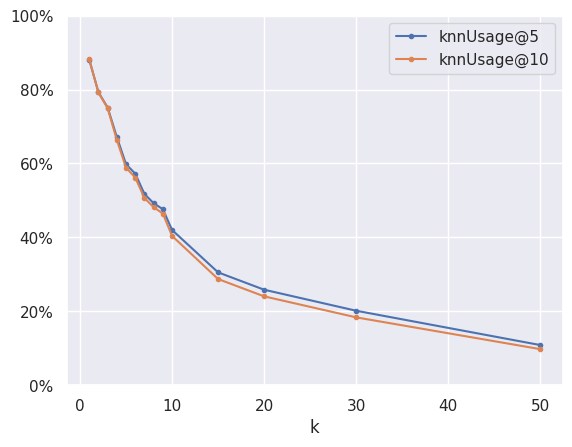

In [43]:
import matplotlib.ticker as mtick

ax = (mdf.groupby('k')[['knnUsage@5', 'knnUsage@10']].mean()*100).plot(style='.-')
ax.set_ylim((0, 100))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
nbutils.download_matplotlib(ax.figure, f'11_knn_usage_k_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

Cannot show ipywidgets in text

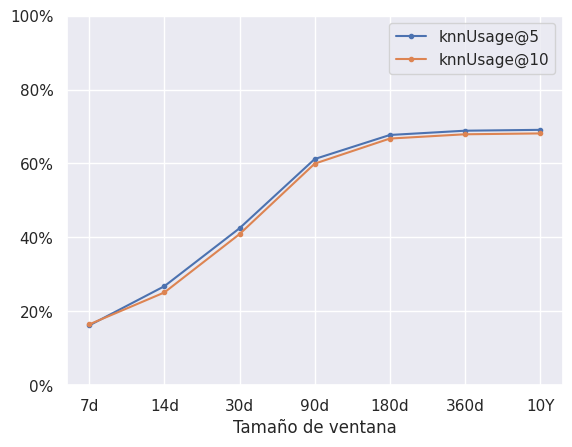

In [44]:
order = param_grid.param_grid[0]['window_size']
_toplot = (mdf.groupby('window_size')[['knnUsage@5', 'knnUsage@10']].mean()*100).loc[order]

ax = _toplot.plot(style='.-')
ax.set_ylim((0, 100))
ax.set_xlabel('Tamaño de ventana')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
nbutils.download_matplotlib(ax.figure, f'11_knn_usage_window_size_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

In [45]:
_toplot = mdf_mean.reset_index().copy()
_toplot['days'] = pd.to_timedelta(_toplot['window_size']).dt.days
_toplot = _toplot.sort_values(['k', 'days'])
# _toplot['color'] = _toplot['window_size'] + ',' + _toplot['metric']

fig = px.line(
    _toplot, 
    x='k', 
    y=KNN_ANALYZE_METRIC, 
    color='window_size', 
    markers=True, 
    line_dash='metric', 
    hover_data='time@10',
    # color_discrete_sequence=px.colors.sequential.Turbo,
)
display(nbutils.download_plotly(fig, f'11_knn_results_k-size_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf'))
fig

/tmp/ipykernel_3377971/3185427442.py:2: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  _toplot['days'] = pd.to_timedelta(_toplot['window_size']).dt.days


Cannot show ipywidgets in text

Cannot show ipywidgets in text

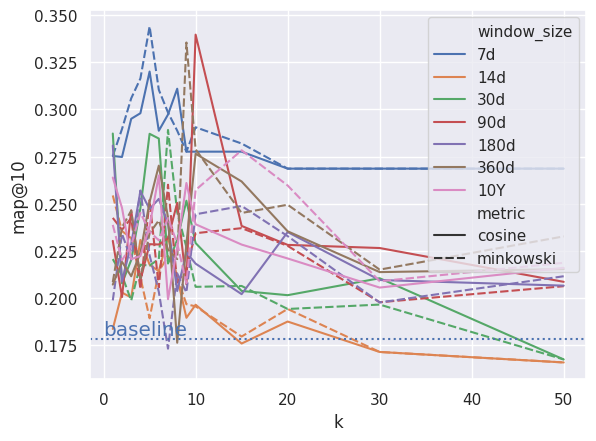

In [46]:
baseline = baseline = bdf[KNN_ANALYZE_METRIC].mean()

ax = sns.lineplot(_toplot, 
    x='k', 
    y=KNN_ANALYZE_METRIC, 
    hue='window_size', 
    # markers=True, 
    style='metric', 
    # hover_data='time@10',
)
ax.axhline(baseline, linestyle=':')
ax.text(0, baseline, "baseline", 
        color=ax.lines[-1].get_color(),
        ha='left', 
        va='bottom',
        fontsize='large',
)
# ax.set_xlabel('log')
# ax.set_ylim((0,0.7))
nbutils.download_matplotlib(ax.figure, f'11_knn_results_all_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

Cannot show ipywidgets in text

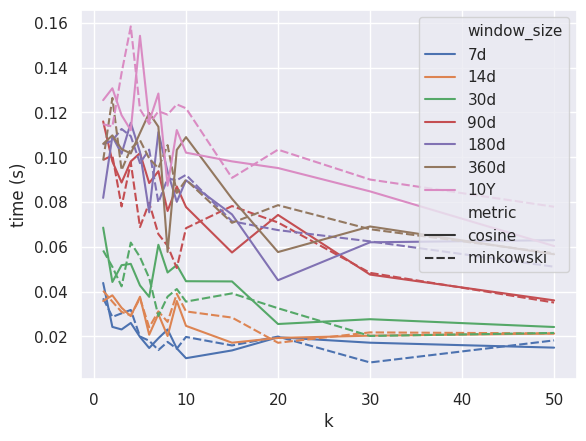

In [47]:
baseline = baseline = bdf[KNN_ANALYZE_METRIC].mean()

ax = sns.lineplot(_toplot, 
    x='k', 
    y='time@10', 
    hue='window_size', 
    # markers=True, 
    style='metric', 
    # hover_data='time@10',
)
# ax.set_xscale('log')
ax.set_ylabel('time (s)')
nbutils.download_matplotlib(ax.figure, f'11_knn_results_time_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

In [48]:
_toplot = mdf.groupby(['window_size', 'metric']).mean().reset_index()
_toplot['days'] = pd.to_timedelta(_toplot['window_size']).dt.days
_toplot = _toplot.sort_values('days')

px.bar(
    _toplot,
    x='window_size',
    y=KNN_ANALYZE_METRIC,
    color='metric',
    hover_data='time@10',
    # pattern_shape='metric',
    barmode='group',
)

/tmp/ipykernel_3377971/783071194.py:2: FutureWarning:

Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.

